# TTS Inference

This notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. This script currently uses a two step inference procedure. First, a model is used to generate a mel spectrogram from text. Second, a model is used to generate audio from a mel spectrogram.

Currently supported models are:
Mel Spectrogram Generators:
- Tacotron 2
- Glow-TTS

Audio Generators
- WaveGlow
- SqueezeWave
- UniGlow
- MelGAN
- HiFiGAN
- Two Stage Models
    - Griffin-Lim

# License

> Copyright 2020 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# # If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 torchtext==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install wget unidecode
# BRANCH = 'r1.0.0rc1'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[tts]

'\nYou can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.\nInstructions for setting up Colab are as follows:\n1. Open a new Python 3 notebook.\n2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)\n3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)\n4. Run this cell to set up dependencies.\n'

In [2]:
supported_spec_gen = ["tacotron2", "glow_tts"]
supported_audio_gen = ["waveglow", "squeezewave", "uniglow", "melgan", "hifigan", "two_stages"]

print("Choose one of the following spectrogram generators:")
print([model for model in supported_spec_gen])
spectrogram_generator = "tacotron2"
print("Choose one of the following audio generators:")
print([model for model in supported_audio_gen])
audio_generator = "hifigan"

assert spectrogram_generator in supported_spec_gen
assert audio_generator in supported_audio_gen

if audio_generator=="two_stages":
    print("Choose one of the following mel-to-spec convertor:")
    # supported_mel2spec = ["psuedo_inverse", "encoder_decoder"] - No encoder_decoder checkpoint atm
    supported_mel2spec = ["psuedo_inverse"]
    print([model for model in supported_mel2spec])
    mel2spec = input()
    print("Choose one of the following linear spectrogram vocoders:")
    # supported_linear_vocoders = ["griffin_lim", "degli"]  - No deep_gli checkpoint atm
    supported_linear_vocoders = ["griffin_lim"]
    print([model for model in supported_linear_vocoders])
    linvocoder = input()
    assert mel2spec in supported_mel2spec
    assert linvocoder in supported_linear_vocoders

Choose one of the following spectrogram generators:
['tacotron2', 'glow_tts']
Choose one of the following audio generators:
['waveglow', 'squeezewave', 'uniglow', 'melgan', 'hifigan', 'two_stages']


# Load model checkpoints

Note: For best quality with Glow TTS, please update the glow tts yaml file with the path to cmudict

In [3]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.asr.parts import parsers
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

SAMPLE_RATE = 22050

nemopath = "/home/jasoli/nemo/NeMo/examples/tts/nemottsmodels/1.0.0/"

def load_spectrogram_model():
    override_conf = None
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
        # return SpectrogramGenerator.from_pretrained(pretrained_model, override_config_path=override_conf)
        return Tacotron2Model.restore_from("/mnt/hdd/experiment_results/temp/1852510_Tacotron_fmax_textnorm/Tacotron2/2021-03-18_18-39-13/checkpoints/Tacotron2.nemo")
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        pretrained_model = "tts_en_glowtts"
        conf = GlowTTSModel.restore_from(nemopath+pretrained_model+".nemo", return_config=True)
        conf.parser.cmu_dict_path = "/home/jasoli/nemo/NeMo/tutorials/tts/cmudict-0.7b"
        return GlowTTSModel.restore_from(nemopath+pretrained_model+".nemo", override_config_path=conf)
    else:
        raise NotImplementedError
        
def load_vocoder_model():
    RequestPseudoInverse = False
    TwoStagesModel = False
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow_88m"
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "tts_squeezewave"
        return SqueezeWaveModel.restore_from(nemopath+pretrained_model+".nemo")
    elif audio_generator == "uniglow":
        from nemo.collections.tts.models import UniGlowModel
        pretrained_model = "tts_uniglow"
        return UniGlowModel.restore_from(nemopath+pretrained_model+".nemo")
    elif audio_generator == "melgan":
        from nemo.collections.tts.models import MelGanModel
        pretrained_model = "tts_melgan"
        return MelGanModel.restore_from("/mnt/hdd/experiment_results/temp/1852518_MelGAN_fmax/MelGan/2021-03-18_19-08-13/checkpoints/MelGan.nemo")
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        pretrained_model = "tts_hifigan"
        return HifiGanModel.restore_from(nemopath+pretrained_model+".nemo")
    elif audio_generator == "two_stages":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': NFFT, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': SAMPLE_RATE, 'n_fft': NFFT, 
                                   'mel_fmin': 0, 'mel_fmax': FMAX, 'mel_freq': NMEL}}}
        model = TwoStagesModel(cfg)
        if mel2spec == "encoder_decoder":
            from nemo.collections.tts.models.ed_mel2spec import EDMel2SpecModel
            pretrained_mel2spec_model = "EncoderDecoderMelToSpec-22050Hz"
            mel2spec_model = EDMel2SpecModel.from_pretrained(pretrained_mel2spec_model)
            model.set_mel_to_spec_model(mel2spec_model)

        if linvocoder == "degli":
            from nemo.collections.tts.models.degli import DegliModel
            pretrained_linvocoder_model = "DeepGriffinLim-22050Hz"
            linvocoder_model = DegliModel.from_pretrained(pretrained_linvocoder_model)
            model.set_linear_vocoder(linvocoder_model)
            
        TwoStagesModel = True

    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model)
        with open_dict(model._cfg):
            validate_parameters(model._cfg.sample_rate, model._cfg.n_fft, model._cfg.n_mels, model._cfg.fmax)
    return model

spec_gen = load_spectrogram_model().cuda()
vocoder = load_vocoder_model().cuda()

[NeMo W 2021-03-22 18:24:08 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[NeMo W 2021-03-22 18:24:08 experimental:27] Module <class 'nemo.collections.asr.models.clustering_diarizer.ClusteringDiarizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-03-22 18:24:09 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali.AudioToCharDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-03-22 18:24:10 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:104: UserWarning: 
    GeForce GT 710 with CUDA capability sm_35 is not compatible with the current PyTorch installation.
    The current PyTorch ins

[NeMo I 2021-03-22 18:24:11 features:247] PADDING: 16
[NeMo I 2021-03-22 18:24:11 features:264] STFT using torch
[NeMo I 2021-03-22 18:24:15 modelPT:376] Model Tacotron2Model was successfully restored from /mnt/hdd/experiment_results/temp/1852510_Tacotron_fmax_textnorm/Tacotron2/2021-03-18_18-39-13/checkpoints/Tacotron2.nemo.


[NeMo W 2021-03-22 18:24:17 modelPT:132] Please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2021-03-22 18:24:17 modelPT:139] Please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150
    dataloader_params:
      drop_last: false
      shuffle: false
      batc

[NeMo I 2021-03-22 18:24:17 features:247] PADDING: 0
[NeMo I 2021-03-22 18:24:17 features:264] STFT using torch
[NeMo I 2021-03-22 18:24:18 features:247] PADDING: 0
[NeMo I 2021-03-22 18:24:18 features:264] STFT using torch
[NeMo I 2021-03-22 18:24:18 hifigan:69] training on ground-truth mels
[NeMo I 2021-03-22 18:24:20 modelPT:376] Model HifiGanModel was successfully restored from /home/jasoli/nemo/NeMo/examples/tts/nemottsmodels/1.0.0/tts_hifigan.nemo.


In [4]:
def infer(spec_gen_model, vocder_model, str_input):
    with torch.no_grad():
        parsed = spec_gen.parse(str_input)
        spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
        audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
    if isinstance(spectrogram, torch.Tensor):
        spectrogram = spectrogram.to('cpu').numpy()
    if len(spectrogram.shape) == 3:
        spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [5]:
text_to_generate = "Input what you want the model to say."
spec, audio = infer(spec_gen, vocoder, text_to_generate)

# Show Audio and Spectrogram

In [6]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=SAMPLE_RATE)

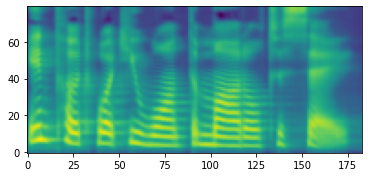

In [7]:
%matplotlib inline
imshow(spec, origin="lower")
plt.show()

In [8]:
# audio_denoised = vocoder.denoise(audio=torch.tensor(audio).cuda(), strength=0.05)
# ipd.Audio(audio_denoised.cpu().numpy(), rate=SAMPLE_RATE)

In [9]:
!ls /mnt/hdd/experiment_results/temp/1852518_MelGAN_fmax/MelGan/2021-03-18_19-08-13/checkpoints

'MelGan---val_loss=7.66-epoch=599.ckpt'   MelGan-last.ckpt
'MelGan---val_loss=7.90-epoch=449.ckpt'   MelGan.nemo
'MelGan---val_loss=8.16-epoch=299.ckpt'
